# Library Imports

In [1]:
texts=["Sahte Veri Konuları","Sahte Veri Kelime Yoğunluğu","Gerçek Veri Konuları","Gerçek Veri Kelime Yoğunluğu","Kelime Uzunluk Histogramı",
      "EĞİTİM 1 MODEL DOĞRULUK ORANI CANLI","EĞİTİM 1 MODEL KAYIP ORANI CANLI","EĞİTİM 2 MODEL DOĞRULUK ORANI CANLI","EĞİTİM 2 MODEL KAYIP ORANI CANLI",
       "GERÇEK VE SAHTE VERİ SAYILARININ PASTASI","CONFUSION MATRİX","ROC EĞRİSİ"
      ]
pngs=["d1.png","d2.png","d3.png","d4.png","d5.png","d11.png","d12.png","d13.png","d14.png","d16.png","d17.png","d18.png"]
sira=0

In [2]:
    import threading
    import gensim
    import warnings
    warnings.filterwarnings('ignore')
    
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import nltk
    import re
    from wordcloud import WordCloud
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
    from sklearn.model_selection import train_test_split
    from sklearn import metrics
    from sklearn.metrics import classification_report, accuracy_score
    from sklearn.linear_model import LogisticRegression
    
    tstart = False

In [3]:
# Exploring Fake News

def start(threadname,test_size,epochs_size):
    global tstart
    if tstart==True:
        return 0
    tstart=True
 
    print(test_size)
    print(epochs_size)
    print(type(test_size))
    fake = pd.read_csv("Fake.csv")
    
    fake.head()

    #Counting by Subjects 
    for key,count in fake.subject.value_counts().iteritems():
        print(f"{key}:\t{count}")

    #Getting Total Rows
    print(f"Total Records:\t{fake.shape[0]}")

    plt.figure(figsize=(8,5))
    sns.countplot("subject", data=fake)
    plt.legend()
    plt.savefig('d1.png', dpi=300, bbox_inches='tight')
    plt.show()
 
    plt.close()

    #Word Cloud
    text = ''
    for news in fake.text.values:
        text += f" {news}"
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.legend()
    plt.savefig('d2.png', dpi=300, bbox_inches='tight')
    plt.show()
 
    plt.close()
    del text

# Exploring Real news

    real = pd.read_csv("True.csv")
    real.head()

### Difference in Text
#Real news seems to have source of publication which is not present in fake news set

#Looking at the data:
#- most of text contains reuters information such as "**WASHINGTON (Reuters)**".
#- Some text are tweets from Twitter 
#- Few text do not contain any publication info

# Cleaning Data
#Removing Reuters or Twitter Tweet information from the text 

#- Text can be splitted only once at " - " which is always present after mentioning source of publication, this gives us publication part and text part
#- If we do not get text part, this means publication details was't given for that record
#- The Twitter tweets always have same source, a long text of max 259 characters 

    unknown_publishers = []
    for index,row in enumerate(real.text.values):
        try:
            record = row.split(" -", maxsplit=1)
            #if no text part is present, following will give error
            record[1]
            #if len of piblication part is greater than 260
            #following will give error, ensuring no text having "-" in between is counted
            assert(len(record[0]) < 260)
        except:
            unknown_publishers.append(index)

    #Thus we have list of indices where publisher is not mentioned
    #lets check
 
    real.iloc[unknown_publishers].text
    #true, they do not have text like "WASHINGTON (Reuters)"

#While looking at texts that do not contain publication info such as which reuter, we noticed one thing.

#**Text at index 8970 is empty**

    real.iloc[8970]
    #yep empty
    #will remove this soon

    #Seperating Publication info, from actual text
    publisher = []
    tmp_text = []
    for index,row in enumerate(real.text.values):
        if index in unknown_publishers:
            #Add unknown of publisher not mentioned
            tmp_text.append(row)

            publisher.append("Unknown")
            continue
        record = row.split(" -", maxsplit=1)
        publisher.append(record[0])
        tmp_text.append(record[1])

    #Replace existing text column with new text
    #add seperate column for publication info
    real["publisher"] = publisher
    real["text"] = tmp_text

    del publisher, tmp_text, record, unknown_publishers

    real.head()

#New column called "Publisher" has been added.


    #checking for rows with empty text like row:8970
    [index for index,text in enumerate(real.text.values) if str(text).strip() == '']
    #seems only one :)

    #dropping this record
    real = real.drop(8970, axis=0)

    # checking for the same in fake news
    empty_fake_index = [index for index,text in enumerate(fake.text.values) if str(text).strip() == '']
    print(f"No of empty rows: {len(empty_fake_index)}")
    fake.iloc[empty_fake_index].tail()

#**630 Rows in Fake news with empty text**

#Also noticed fake news have a lot of CPATIAL-CASES. Could preserve Cases of letters, but as we are using Google's pretrained word2vec vectors later on, which haswell-formed lower cases word. We will contert to lower case.

#The text for these rows seems to be present in title itself. Lets merge title and text to solve these cases.

#Looking at publication Information
# Checking if Some part of text has been included as publisher info... No such cases it seems :)

# for name,count in real.publisher.value_counts().iteritems():
#     print(f"Name: {name}\nCount: {count}\n")

    #Getting Total Rows
    print(f"Total Records:\t{real.shape[0]}")

    #Counting by Subjects 
    for key,count in real.subject.value_counts().iteritems():
      print(f"{key}:\t{count}")

    sns.countplot(x="subject", data=real)
    plt.legend()
    plt.savefig('d3.png', dpi=300, bbox_inches='tight')
    plt.show()
 
    plt.close()

    #WordCloud For Real News
    text = ''
    for news in real.text.values:
        text += f" {news}"
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = set(nltk.corpus.stopwords.words("english"))).generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.legend()
    plt.savefig('d4.png', dpi=300, bbox_inches='tight')
    plt.show()
 
    plt.close()
    del text

# Preprocessing Text

    # Adding class Information
    real["class"] = 1
    fake["class"] = 0

    #Combining Title and Text
    real["text"] = real["title"] + " " + real["text"]
    fake["text"] = fake["title"] + " " + fake["text"]

    # Subject is diffrent for real and fake thus dropping it
    # Aldo dropping Date, title and Publication Info of real
    real = real.drop(["subject", "date","title",  "publisher"], axis=1)
    fake = fake.drop(["subject", "date", "title"], axis=1)
    print(real)
    print(fake)

    #Combining both into new dataframe
    data = real.append(fake, ignore_index=True)
    del real, fake

    # Download following if not downloaded in local machine

    # nltk.download('stopwords')
    # nltk.download('punkt')

#Removing StopWords, Punctuations and single-character words

    y = data["class"].values
    #Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
    X = []
    stop_words = set(nltk.corpus.stopwords.words("english"))
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    for par in data["text"].values:
        tmp = []
        sentences = nltk.sent_tokenize(par)
        for sent in sentences:
            sent = sent.lower()
            tokens = tokenizer.tokenize(sent)
            filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
            tmp.extend(filtered_words)
        X.append(tmp)

    del data

### Vectorization -- Word2Vec

#Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

#Word embedding is the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

#[Here](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) is a nice article about it.




#### Let's create and check our own Word2Vec model with **gensim**

    

    #Dimension of vectors we are generating
    EMBEDDING_DIM = 100

    #Creating Word Vectors by Word2Vec Method (takes time...)
    w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

#vocab size
    len(w2v_model.wv.vocab)

#We have now represented each of 122248 words by a 100dim vector.

### Exploring Vectors

#Lets checkout these vectors

#see a sample vector for random word, lets say Corona 
    w2v_model["corona"]

    w2v_model.wv.most_similar("iran")

    w2v_model.wv.most_similar("fbi")

    w2v_model.wv.most_similar("facebook")

    w2v_model.wv.most_similar("computer")

    #Feeding US Presidents
    w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])
    #First was Bush

#**Looking at the similar words, vectors are well formed for these words :)**


#These Vectors will be passed to LSTM/GRU instead of words. 1D-CNN can further be used to extract features from the vectors. 


#Keras has implementation called "**Embedding Layer**" which would create word embeddings(vectors). Since we did that with gensim's word2vec, we will load these vectors into embedding layer and make the layer non-trainable.




#We cannot pass string words to embedding layer, thus need some way to represent each words by numbers.

#Tokenizer can represent each word by number

    # Tokenizing Text -> Repsesenting each word by a number
    # Mapping of orginal word to number is preserved in word_index property of tokenizer

    #Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)

    X = tokenizer.texts_to_sequences(X)

    # lets check the first 10 words of first news
    #every word has been represented with a number
    X[0][:10]

    #Lets check few word to numerical replesentation
    #Mapping is preserved in dictionary -> word_index property of instance
    word_index = tokenizer.word_index
    for word, num in word_index.items():
        print(f"{word} -> {num}")
        if num == 10:
            break        

#**Notice it starts with 1**


#We can pass numerical representation of words into neural network.

#We can use Many-To-One (Sequence-To-Word) Model of RNN, as we have many words in news as input and one output ie Probability of being Real.

#For Many-To-One model, lets use a fixed size input. 


    # For determining size of input...

    # Making histogram for no of words in news shows that most news article are under 700 words.
    # Lets keep each news small and truncate all news to 700 while tokenizing
    plt.hist([len(x) for x in X], bins=500)
    plt.legend()
    plt.savefig('d5.png', dpi=300, bbox_inches='tight')
    plt.show()
 
    plt.close()

    # Its heavily skewed. There are news with 5000 words? Lets truncate these outliers :) 

    nos = np.array([len(x) for x in X])
    len(nos[nos  < 700])
    # Out of 48k news, 44k have less than 700 words

    #Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
    maxlen = 700 

    #Making all news of size maxlen defined above
    X = pad_sequences(X, maxlen=maxlen)

    #all news has 700 words (in numerical form now). If they had less words, they have been padded with 0
    # 0 is not associated to any word, as mapping of words started from 1
    # 0 will also be used later, if unknows word is encountered in test set
    len(X[0])

    # Adding 1 because of reserved 0 index
    # Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
    # Thus our vocab size inceeases by 1
    vocab_size = len(tokenizer.word_index) + 1

    # Function to create weight matrix from word2vec gensim model
    def get_weight_matrix(model, vocab):
        # total vocabulary size plus 0 for unknown words
        vocab_size = len(vocab) + 1
        # define weight matrix dimensions with all 0
        weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
        # step vocab, store vectors using the Tokenizer's integer mapping
        for word, i in vocab.items():
            weight_matrix[i] = model[word]
        return weight_matrix

#We Create a matrix of mapping between word-index and vectors. We use this as weights in embedding layer

#Embedding layer accepts numecical-token of word and outputs corresponding vercor to inner layer.

#It sends vector of zeros to next layer for unknown words which would be tokenized to 0.


#Input length of Embedding Layer is the length of each news (700 now due to padding and truncating)

    #Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
    embedding_vectors = get_weight_matrix(w2v_model, word_index)

    #Defining Neural Network
    model = Sequential()
    #Non-trainable embeddidng layer
    model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
    #LSTM 
    model.add(LSTM(units=128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    del embedding_vectors

    model.summary()

    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y) 

    history_1=model.fit(X_train, y_train, validation_split=test_size, epochs=1)

    #Prediction is in probability of news being real, so converting into classes
    # Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
    y_pred = (model.predict(X_test) >= 0.5).astype("int")

    accuracy_score(y_test, y_pred)

    print(classification_report(y_test, y_pred))

    del model

### Using Pre-Trained Word2Vec Vectors

#**Needs 12GB RAM and 4GB HardDisk Space **

#Now, instead of creating word vectors, let us use pre-trained vectors trained on part of **Google News dataset** (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases.  Source: https://code.google.com/archive/p/word2vec/

#**Please download model file from**: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing


#Or add Dataset from https://www.kaggle.com/sandreds/googlenewsvectorsnegative300


    #invoke garbage collector to free ram
    import gc
    gc.collect()

    from gensim.models.keyedvectors import KeyedVectors

    # Takes RAM 
    word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
    EMBEDDING_DIM=300

### Exploring these trained Vectors

# word_vectors.most_similar('usa')

# word_vectors.most_similar('fbi')

# word_vectors.most_similar('Republic')

    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in word_index.items():
        try:
            embedding_vector = word_vectors[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

    del word_vectors 

    model = Sequential()
    model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=maxlen, trainable=False))
    model.add(Conv1D(activation='relu', filters=4, kernel_size=4))
    model.add(MaxPool1D())
    model.add(LSTM(units=128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    del embedding_matrix

    model.summary()
    history_2=model.fit(X_train, y_train, validation_split=test_size, epochs=100)

    y_pred = (model.predict(X_test) > 0.5).astype("int")

    accuracy_score(y_test, y_pred)
    print(history_1.history.keys())
    # summarize history for accuracy
    plt.plot(history_1.history['acc'])
    plt.plot(history_1.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('d11.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    # summarize history for loss
    plt.plot(history_1.history['loss'])
    plt.plot(history_1.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('d12.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(history_2.history.keys())
    # summarize history for accuracy
    plt.plot(history_2.history['acc'])
    plt.plot(history_2.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('d13.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    # summarize history for loss
    plt.plot(history_2.history['loss'])
    plt.plot(history_2.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('d15.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    fake = pd.read_csv("Fake.csv")
    len(fake)
    true = pd.read_csv("True.csv")
    len(true)

    x=["Sahte","Gerçek"]
    h=[len(fake),len(true)]

    colors = ['b','r']
    plt.pie(h, labels=x, colors=colors,
    startangle=60, shadow=True, explode=(0, 0),
    radius=1.22, autopct='%1.1f%%')
    plt.xlabel(h[0])
    plt.ylabel(h[1])
        # plotting legend
    plt.legend()
  
    plt.savefig('d16.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    from sklearn.metrics import confusion_matrix
    import sklearn.metrics as mt
    cf_matrix = mt.confusion_matrix(y_test, y_pred)
 
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.legend()
    ## Display the visualization of the Confusion Matrix.
    plt.savefig('d17.png', dpi=300, bbox_inches='tight')
    plt.show()

    log_regression = LogisticRegression()
    log_regression.fit(X_train,y_train)

    y_pred_proba = log_regression.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    
    plt.plot(fpr,tpr)
    plt.title("ROC GRAPH")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.savefig('d18.png', dpi=300, bbox_inches='tight')
    plt.show()
#**Do Upvote if you find this notebook useful.**

#**Thanks**




In [4]:

from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtWidgets import QTableWidgetItem
from PyQt5.QtWidgets import *
from PyQt5.QtGui import QPixmap
import pandas as pd




class Ui_MainWindow(object):
    def clicked_btn_save(self):
       print("kaydedildi")
        
    def clicked_btn_start(self):
        test_size=float(self.lineEdit_train.text())
       
        epochs_size=int(self.lineEdit_epoch.text())
        t1 = threading.Thread(target=start, args=("thread-1",test_size,epochs_size))
        t1.start()
    def clicked_btn_next(self):
        global sira
        global texts
        global pngs
        
        if sira!=len(pngs)-1:
            sira+=1
            self.button_prev.setEnabled(True)
        else :
            self.button_next.setEnabled(False)
        self.label_p1.setText(texts[sira])
        pixmap3 = QPixmap(pngs[sira])
        self.graphicsView_4.setPixmap(pixmap3)
    def clicked_btn_prev(self):
        global sira
        global texts
        global pngs
       
        if sira==0:
            self.button_prev.setEnabled(False)
        else:
            sira-=1
            self.button_next.setEnabled(True)
        self.label_p1.setText(texts[sira])
        pixmap3 = QPixmap(pngs[sira])
        self.graphicsView_4.setPixmap(pixmap3)
    # start(test_size,epochs_size)
    def setupUi(self, MainWindow):
        MainWindow.setObjectName("MainWindow")
        MainWindow.resize(1206, 678)
        self.centralwidget = QtWidgets.QWidget(MainWindow)
        self.centralwidget.setObjectName("centralwidget")
        self.tabWidget = QtWidgets.QTabWidget(self.centralwidget)
        self.tabWidget.setGeometry(QtCore.QRect(10, 0, 901, 641))
        self.tabWidget.setObjectName("tabWidget")
        self.tab_3 = QtWidgets.QWidget()
        self.tab_3.setContextMenuPolicy(QtCore.Qt.DefaultContextMenu)
        self.tab_3.setObjectName("tab_3")
        self.label_datacount = QtWidgets.QLabel(self.tab_3)
        self.label_datacount.setGeometry(QtCore.QRect(480, 0, 111, 16))
        self.label_datacount.setObjectName("label_datacount")
        self.label_8 = QtWidgets.QLabel(self.tab_3)
        self.label_8.setGeometry(QtCore.QRect(390, 20, 47, 13))
        self.label_8.setObjectName("label_8")
        self.label_9 = QtWidgets.QLabel(self.tab_3)
        self.label_9.setGeometry(QtCore.QRect(390, 0, 61, 16))
        self.label_9.setObjectName("label_9")
        self.label_10 = QtWidgets.QLabel(self.tab_3)
        self.label_10.setGeometry(QtCore.QRect(390, 40, 51, 16))
        self.label_10.setObjectName("label_10")
      
      
        self.label_falsecount = QtWidgets.QLabel(self.tab_3)
        self.label_falsecount.setGeometry(QtCore.QRect(470, 20, 47, 13))
        self.label_falsecount.setObjectName("label_falsecount")
      
        self.lable_truecount = QtWidgets.QLabel(self.tab_3)
        self.lable_truecount.setGeometry(QtCore.QRect(470, 40, 47, 13))
        self.lable_truecount.setObjectName("lable_truecount")
        self.tableWidget = QtWidgets.QTableWidget(self.tab_3)
        self.tableWidget.setGeometry(QtCore.QRect(10, 80, 561, 491))
        self.tableWidget.setObjectName("tableWidget")
        self.tableWidget.setColumnCount(0)
        self.tableWidget.setRowCount(0)
        self.tabWidget.addTab(self.tab_3, "")
        self.tab_2 = QtWidgets.QWidget()
        self.tab_2.setObjectName("tab_2")
        
        self.graphicsView_4 =QtWidgets.QLabel(self.tab_2)
        self.graphicsView_4.setGeometry(QtCore.QRect(50, 50, 591, 511))
        self.graphicsView_4.setObjectName("graphicsView_4")
        self.label_p1 =QtWidgets.QLabel(self.tab_2)
        self.label_p1.setGeometry(QtCore.QRect(10, 10, 500, 20))
        self.label_p1.setObjectName("label_p1")
        self.button_next = QtWidgets.QPushButton(self.tab_2)
        self.button_next.setGeometry(QtCore.QRect(240, 570, 75, 23))
        self.button_next.setObjectName("button_next")
        self.tabWidget.addTab(self.tab_2, "")
        self.button_prev = QtWidgets.QPushButton(self.tab_2)
        self.button_prev.setGeometry(QtCore.QRect(150, 570, 75, 23))
        self.button_prev.setObjectName("button_prev")
        self.tabWidget.addTab(self.tab_2, "")
        self.tab = QtWidgets.QWidget()
        self.tab.setObjectName("tab")
        
        self.label_14 = QtWidgets.QLabel(self.tab)
        self.label_14.setGeometry(QtCore.QRect(130, 90, 71, 16))
        self.label_14.setObjectName("label_14")
      
        self.button_save = QtWidgets.QPushButton(self.tab)
        self.button_save.setGeometry(QtCore.QRect(240, 190, 75, 23))
        self.button_save.setObjectName("button_save")
        self.label_15 = QtWidgets.QLabel(self.tab)
        self.label_15.setGeometry(QtCore.QRect(130, 150, 91, 16))
        self.label_15.setObjectName("label_15")
        self.lineEdit_train = QtWidgets.QLineEdit(self.tab)
        self.lineEdit_train.setGeometry(QtCore.QRect(250, 150, 113, 20))
        self.lineEdit_train.setObjectName("lineEdit_train")
        self.lineEdit_epoch = QtWidgets.QLineEdit(self.tab)
        self.lineEdit_epoch.setGeometry(QtCore.QRect(250, 90, 113, 20))
        self.lineEdit_epoch.setObjectName("lineEdit_epoch")
        self.tabWidget.addTab(self.tab, "")
        self.tab_4 = QtWidgets.QWidget()
        self.tab_4.setObjectName("tab_4")
        self.label_4 = QtWidgets.QLabel(self.tab_4)
        self.label_4.setGeometry(QtCore.QRect(450, 470, 47, 13))
        self.label_4.setObjectName("label_4")
        self.label_5 = QtWidgets.QLabel(self.tab_4)
        self.label_5.setGeometry(QtCore.QRect(450, 490, 47, 13))
        self.label_5.setObjectName("label_5")
        self.label_6 = QtWidgets.QLabel(self.tab_4)
        self.label_6.setGeometry(QtCore.QRect(450, 450, 47, 13))
        self.label_6.setObjectName("label_6")
        self.label_2 = QtWidgets.QLabel(self.tab_4)
        self.label_2.setGeometry(QtCore.QRect(40, 470, 47, 13))
        self.label_2.setObjectName("label_2")
        self.label_7 = QtWidgets.QLabel(self.tab_4)
        self.label_7.setGeometry(QtCore.QRect(180, 70, 71, 16))
        self.label_7.setObjectName("label_7")
        self.button_start = QtWidgets.QPushButton(self.tab_4)
        self.button_start.setGeometry(QtCore.QRect(230, 460, 75, 23))
        self.button_start.setObjectName("button_start")
        self.label_3 = QtWidgets.QLabel(self.tab_4)
        self.label_3.setGeometry(QtCore.QRect(40, 490, 47, 13))
        self.label_3.setObjectName("label_3")
        self.label = QtWidgets.QLabel(self.tab_4)
        self.label.setGeometry(QtCore.QRect(40, 450, 47, 13))
        self.label.setObjectName("label")
        self.label_12 = QtWidgets.QLabel(self.tab_4)
        self.label_12.setGeometry(QtCore.QRect(30, 90, 481, 141))
        self.label_12.setText("")
        self.label_12.setObjectName("label_12")
        self.label_16 = QtWidgets.QLabel(self.tab_4)
        self.label_16.setGeometry(QtCore.QRect(20, 270, 481, 141))
        self.label_16.setText("")
        self.label_16.setObjectName("label_16")
        self.tabWidget.addTab(self.tab_4, "")
        MainWindow.setCentralWidget(self.centralwidget)

        self.retranslateUi(MainWindow)
        all_data = pd.read_csv('True.csv')    
        self.button_start.clicked.connect(self.clicked_btn_start)
        self.button_save.clicked.connect(self.clicked_btn_save)
        self.button_next.clicked.connect(self.clicked_btn_next)
        self.button_prev.clicked.connect(self.clicked_btn_prev)
        self.tabWidget.setCurrentIndex(0)
        columns = ('title', 'text', 'subject','')
        self.tableWidget.setColumnCount(3)
        self.tableWidget.setRowCount(200)
        self.tableWidget.setHorizontalHeaderLabels(["title","text","subject"])
        i =0
        for index, row in all_data.iterrows():
               self.tableWidget.setItem(i, 0, QTableWidgetItem(str(row["title"])))
               self.tableWidget.setItem(i, 1, QTableWidgetItem("True"))
               self.tableWidget.setItem(i, 2, QTableWidgetItem(str(row["subject"])))
               i+=1    
               if i==100:
                    break
       
    
        all_data = pd.read_csv('Fake.csv')    
        self.button_start.clicked.connect(self.clicked_btn_start)
        self.button_save.clicked.connect(self.clicked_btn_save)
           
        self.tabWidget.setCurrentIndex(0)
        columns = ('title', 'text', 'subject','')
        self.tableWidget.setColumnCount(3)
        self.tableWidget.setRowCount(200)
        self.tableWidget.setHorizontalHeaderLabels(["title","text","subject"])
        self.tableWidget.resizeColumnsToContents()
        self.tableWidget.resizeRowsToContents()
        for index, row in all_data.iterrows():
               self.tableWidget.setItem(i, 0, QTableWidgetItem(str(row["title"])))
               self.tableWidget.setItem(i, 1, QTableWidgetItem("Fake"))
               self.tableWidget.setItem(i, 2, QTableWidgetItem(str(row["subject"])))
               i+=1    
               if i==200:
                    break

    def retranslateUi(self, MainWindow):
        _translate = QtCore.QCoreApplication.translate
        MainWindow.setWindowTitle(_translate("MainWindow", "MainWindow"))
        self.label_datacount.setText(_translate("MainWindow", "Toplam Veri"))
        self.label_8.setText(_translate("MainWindow", "Yanlış Veri"))
        self.label_9.setText(_translate("MainWindow", "Toplam Veri:"))
        self.label_10.setText(_translate("MainWindow", "Doğru Veri"))
        self.label_falsecount.setText(_translate("MainWindow", "yanlış"))
      
        self.lable_truecount.setText(_translate("MainWindow", "Doğru"))
        self.tabWidget.setTabText(self.tabWidget.indexOf(self.tab_3), _translate("MainWindow", "Data"))
        self.tabWidget.setTabText(self.tabWidget.indexOf(self.tab_2), _translate("MainWindow", "Charts"))
       
        self.label_14.setText(_translate("MainWindow", "Epoch,D=2"))
        self.button_save.setText(_translate("MainWindow", "Kaydet"))
        self.label_15.setText(_translate("MainWindow", "Validation Split=0,2"))
        self.tabWidget.setTabText(self.tabWidget.indexOf(self.tab), _translate("MainWindow", "Settigns"))
        self.label_4.setText(_translate("MainWindow", "-"))
        self.label_5.setText(_translate("MainWindow", "-"))
        self.label_6.setText(_translate("MainWindow", "-"))
        self.label_2.setText(_translate("MainWindow", "-"))
        self.label_7.setText(_translate("MainWindow", "Canlı Grafik"))
        self.button_start.setText(_translate("MainWindow", "Başlat"))
        self.button_next.setText(_translate("MainWindow", "Ileri"))
        self.button_prev.setText(_translate("MainWindow", "Geri"))
        self.label_p1.setText(_translate("MainWindow", "-"))
        self.label_3.setText(_translate("MainWindow", "-"))
        self.label.setText(_translate("MainWindow", "-"))
        self.tabWidget.setTabText(self.tabWidget.indexOf(self.tab_4), _translate("MainWindow", "Program"))
        pixmap = QPixmap('d13.png')
        self.label_12.setPixmap(pixmap)
        pixmap2 = QPixmap('d14.png')
        self.label_16.setPixmap(pixmap2)
        global texts
        global pngs
        pixmap3 = QPixmap(pngs[0])
        self.label_p1.setText(texts[0])
        self.graphicsView_4.setPixmap(pixmap3)
        self.graphicsView_4.setScaledContents( True );
        self.label_12.setScaledContents( True );
        self.label_16.setScaledContents( True );
       


def StartPage():
    import sys
    app = QtWidgets.QApplication(sys.argv)
    MainWindow = QtWidgets.QMainWindow()
    ui = Ui_MainWindow()
    ui.setupUi(MainWindow)
    MainWindow.show()
    sys.exit(app.exec_())



kaydedildi
kaydedildi
0.3
100
<class 'float'>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	23481


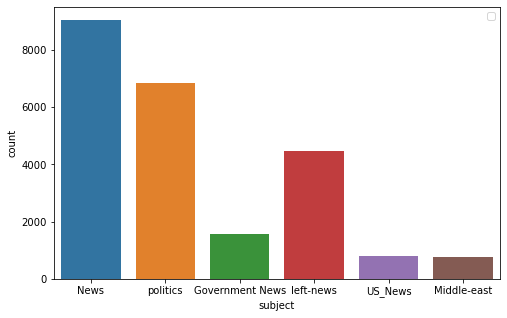

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


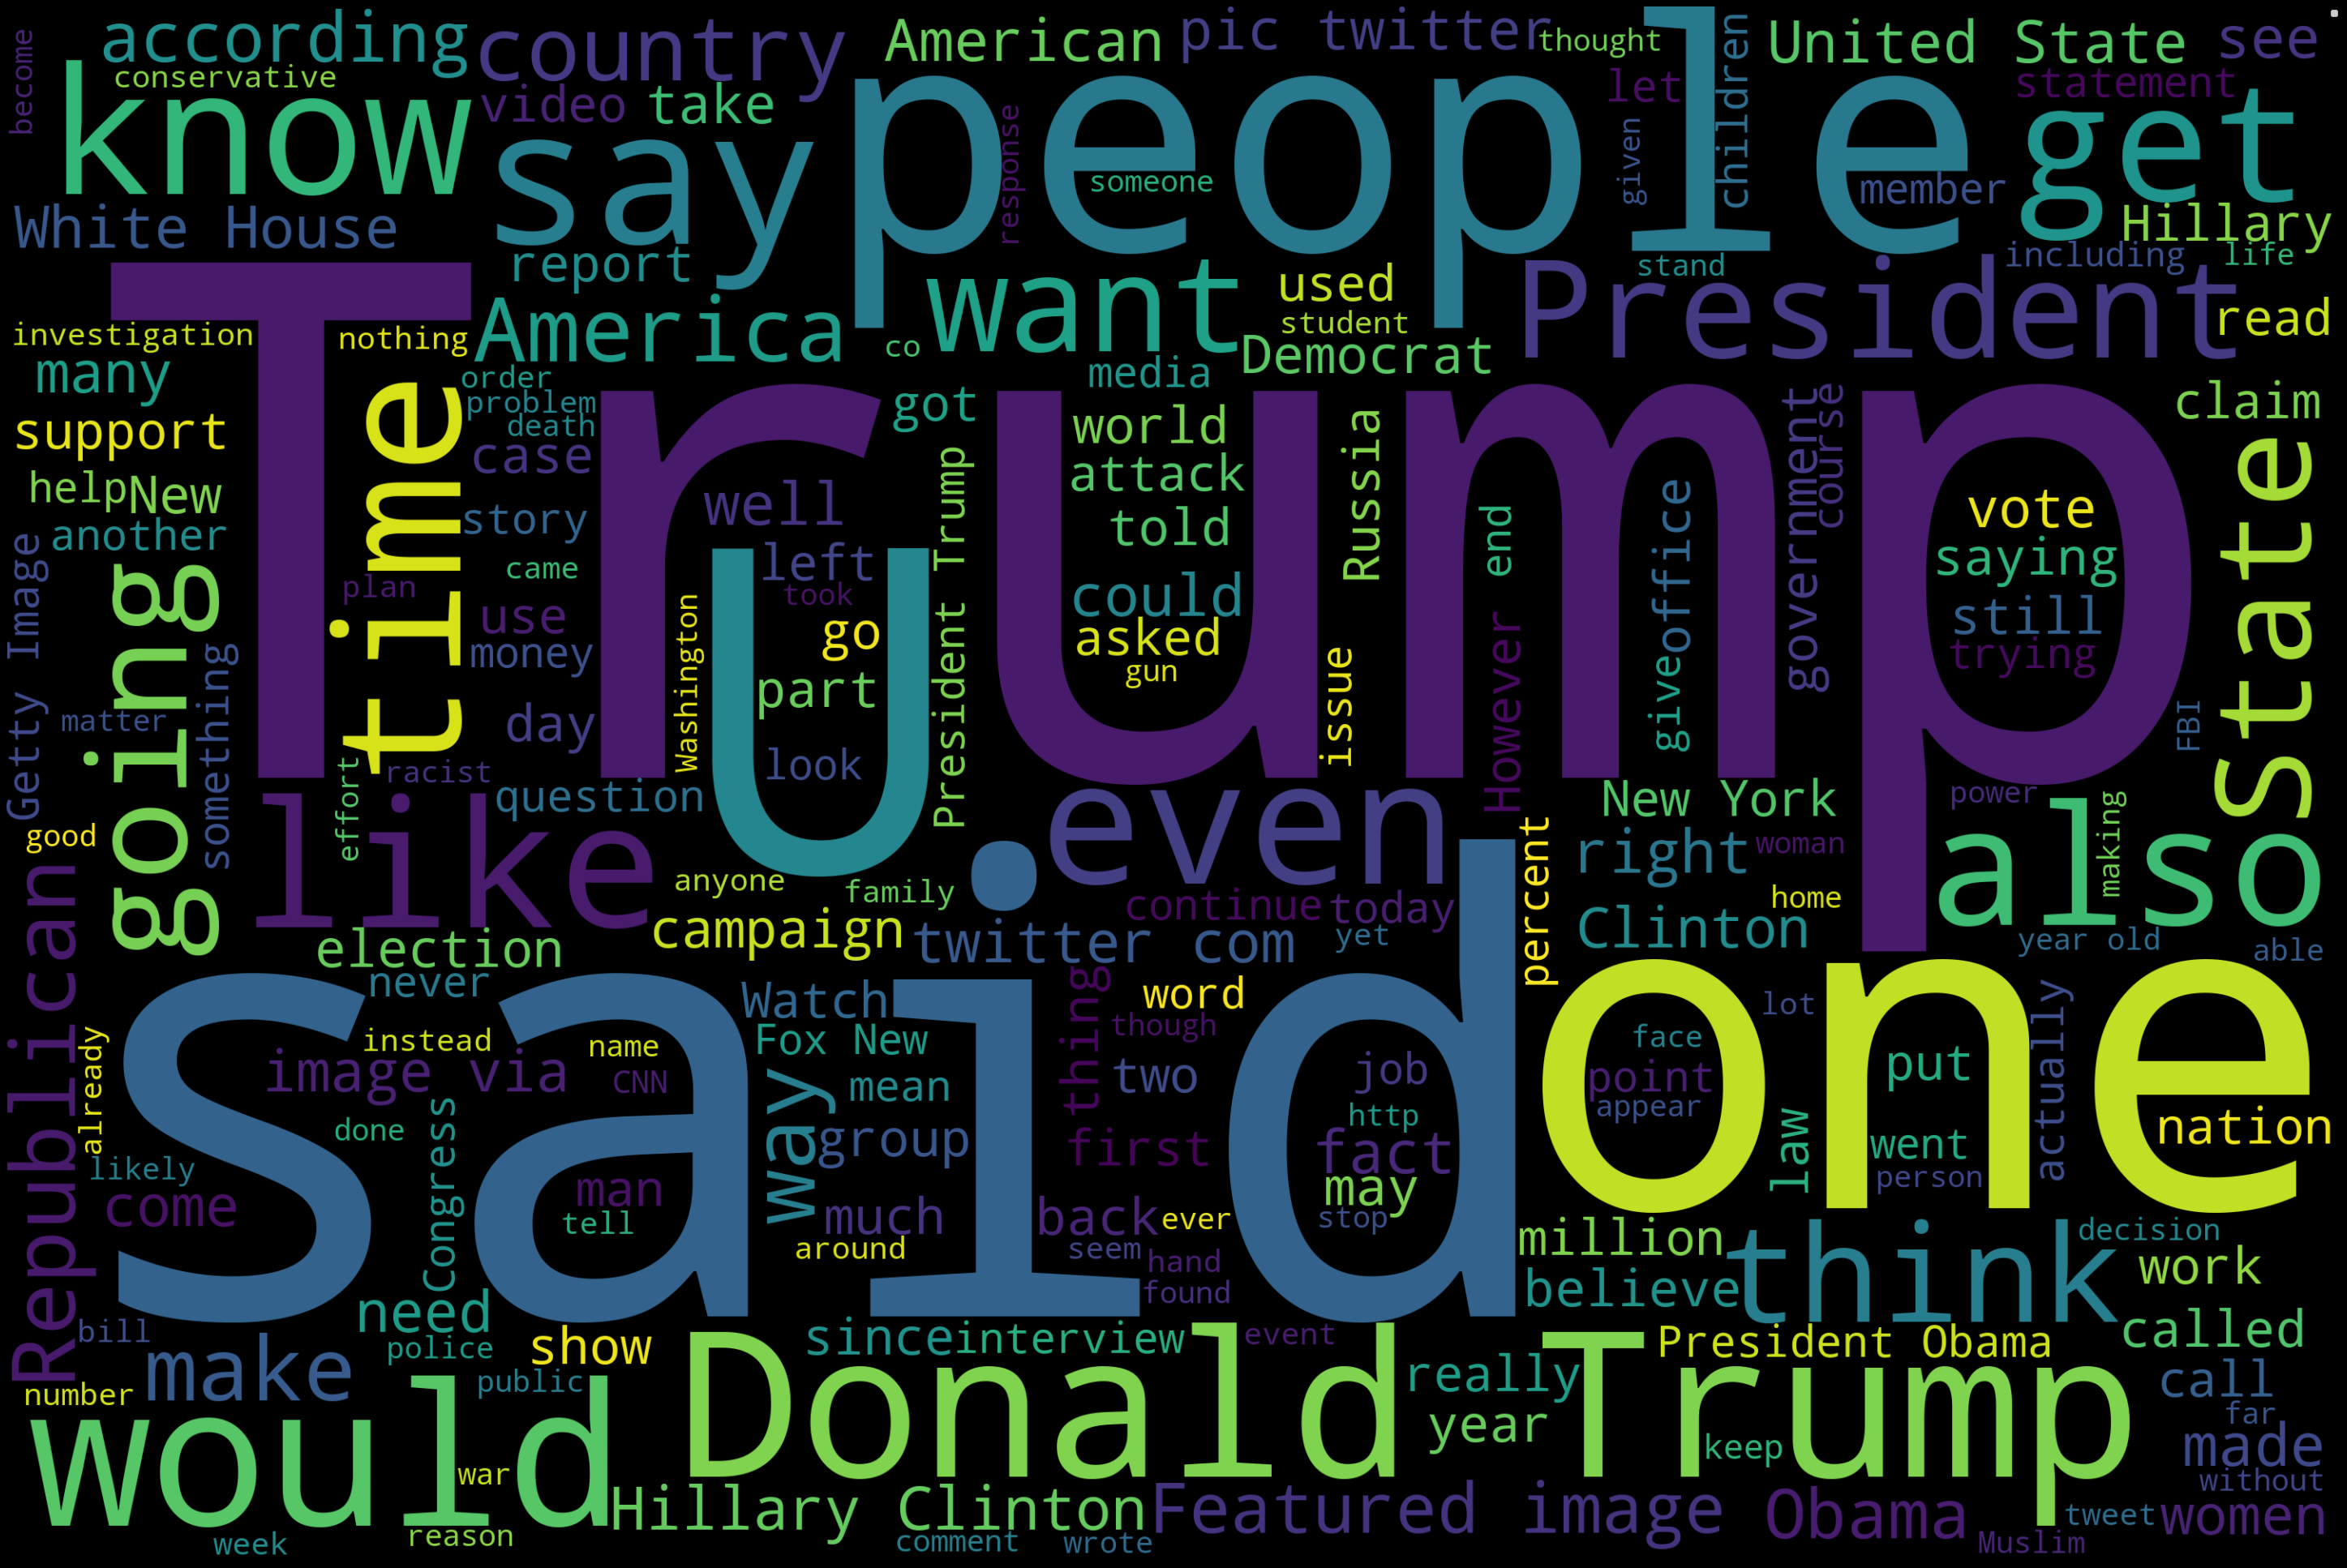

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No of empty rows: 630
Total Records:	21416
politicsNews:	11271
worldnews:	10145


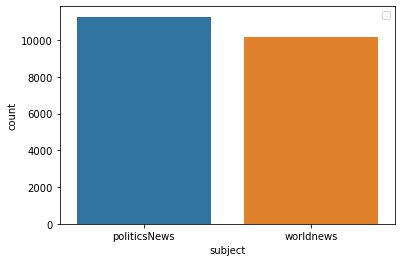

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


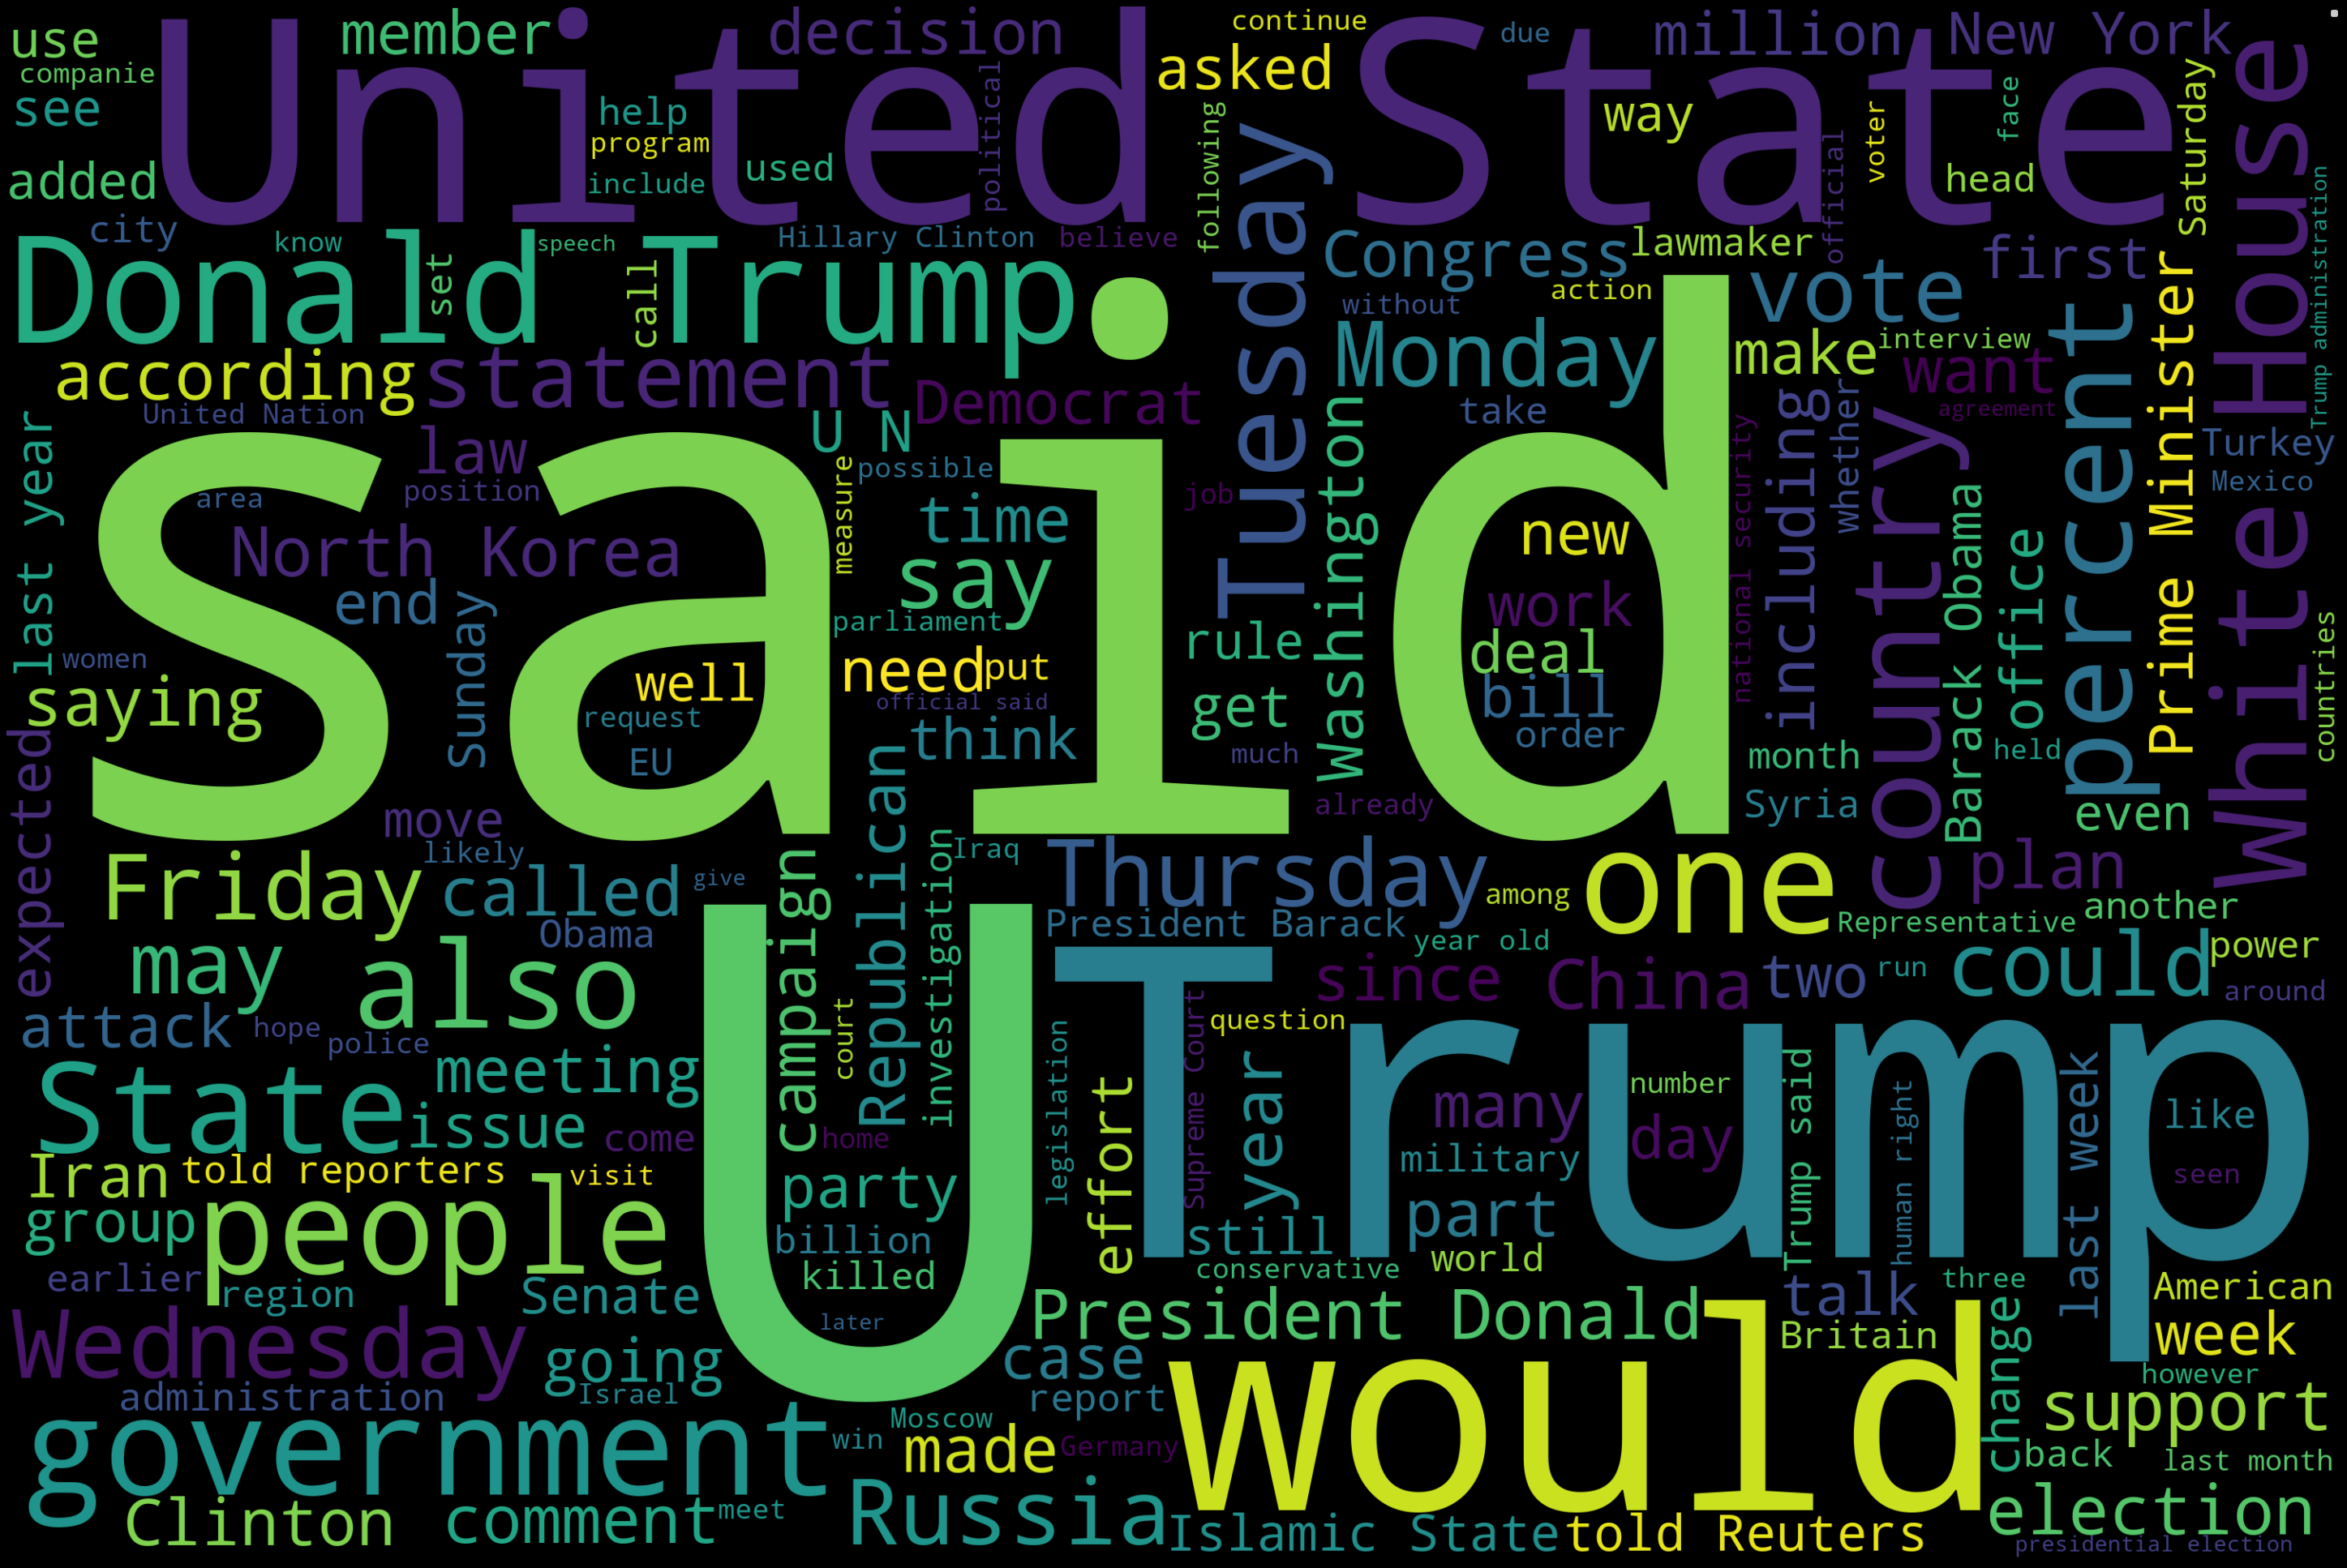

                                                    text  class
0      As U.S. budget fight looms, Republicans flip t...      1
1      U.S. military to accept transgender recruits o...      1
2      Senior U.S. Republican senator: 'Let Mr. Muell...      1
3      FBI Russia probe helped by Australian diplomat...      1
4      Trump wants Postal Service to charge 'much mor...      1
...                                                  ...    ...
21412  'Fully committed' NATO backs new U.S. approach...      1
21413  LexisNexis withdrew two products from Chinese ...      1
21414  Minsk cultural hub becomes haven from authorit...      1
21415  Vatican upbeat on possibility of Pope Francis ...      1
21416  Indonesia to buy $1.14 billion worth of Russia...      1

[21416 rows x 2 columns]
                                                    text  class
0       Donald Trump Sends Out Embarrassing New Year’...      0
1       Drunk Bragging Trump Staffer Started Russian ...      0
2       Sherif

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


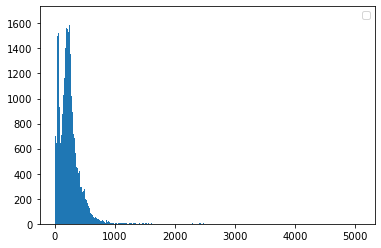

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          12224900  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 12,342,277
Trainable params: 117,377
Non-trainable params: 12,224,900
_________________________________________________________________
737/737 [==============================] - 478s 645ms/step - loss: 0.1338 - acc: 0.9518 - val_loss: 0.0969 - val_acc: 0.9680
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5809
           1       0.97      0.96      0.97      5416

    accuracy 

Epoch 43/100
737/737 [==============================] - 259s 351ms/step - loss: 1.5961e-04 - acc: 1.0000 - val_loss: 0.0868 - val_acc: 0.9860
Epoch 44/100
737/737 [==============================] - 256s 348ms/step - loss: 7.7284e-05 - acc: 1.0000 - val_loss: 0.0921 - val_acc: 0.9857
Epoch 45/100
737/737 [==============================] - 258s 350ms/step - loss: 4.6757e-05 - acc: 1.0000 - val_loss: 0.0958 - val_acc: 0.9860
Epoch 46/100
737/737 [==============================] - 261s 354ms/step - loss: 2.4294e-05 - acc: 1.0000 - val_loss: 0.0992 - val_acc: 0.9860
Epoch 47/100
737/737 [==============================] - 257s 348ms/step - loss: 1.5951e-05 - acc: 1.0000 - val_loss: 0.1025 - val_acc: 0.9858
Epoch 48/100
737/737 [==============================] - 259s 351ms/step - loss: 1.0771e-05 - acc: 1.0000 - val_loss: 0.1050 - val_acc: 0.9862
Epoch 49/100
737/737 [==============================] - 263s 356ms/step - loss: 7.1019e-06 - acc: 1.0000 - val_loss: 0.1080 - val_acc: 0.9862
Epoch 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


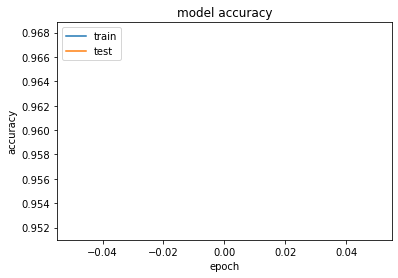

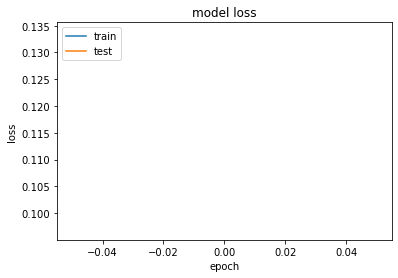

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


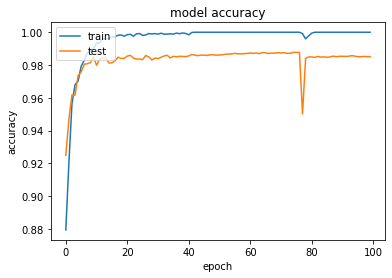

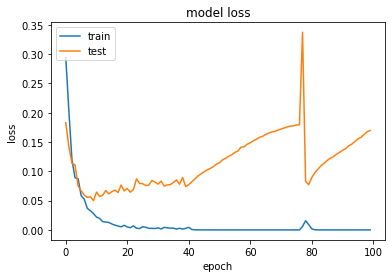

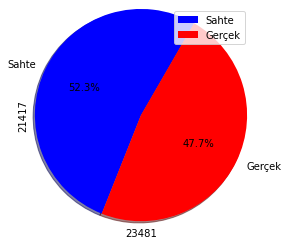

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


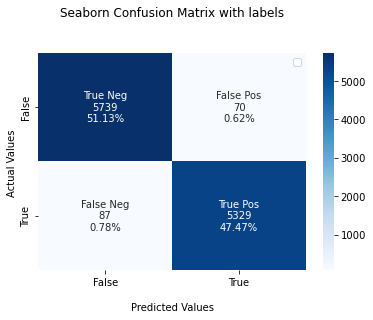

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


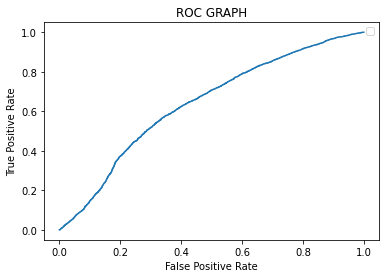

In [ ]:
StartPage()

In [ ]:
print(pngs[0])